# ACX Music Machine Learning algorithm for classification of emotion tags

This Jupyter Notebook is presenting the code that was made as a model that is using Machine Learning to connect emotion tags with music. 

The algorithm is based upon the [Emotify dataset](http://www2.projects.science.uu.nl/memotion/emotifydata/) that contains a folder of 400 mp3-files; 1 minute of length music files in four genres. All of the mp3-files have been given an average of emotion tags that were collected from a number of different people. 

This code is using musical features (like tempo, tonality, and volume) to create a machine learning algorithm that can be applied with new music to annotate emotion tags to the tracks. 

This code should be seen as a prototype or as an idea of concept, that can be expanded and researched further upon. The code itself is based upon a code that was created and provided by associate professor Stefano Fasciani through the course Music and Machine Learning (University of Oslo), and has been modified and adjusted for this particular purpose by Mari Lesteberg, autumn 2020. 

The emotion annotations are: 

| Emotional category   	| Explanation                                          	|
|----------------------	|------------------------------------------------------	|
| Amazement:           	| Feeling of wonder and happiness                      	|
| Solemnity:           	| Feeling of transcendence, inspiration. Thrills       	|
| Tenderness:          	| Sensuality, affect, feeling of love                  	|
| Nostalgia:           	| Dreamy, melancholic, sentimental feelings            	|
| Calmness:            	| Relaxation, serenity, meditativeness                 	|
| Power:               	| Feeling strong, heroic, triumphant, energetic        	|
| Joyful activation:   	| Feels like dancing, bouncy feeling, animated, amused 	|
| Tension:             	| Nervous, impatient, irritated                        	|
| Sadness:             	| Depressed, sorrowful                                 	|

The first bracket of code is importing all necessary libraries:

In [1]:
#import all necessary libraries
import numpy as np
import pandas as pd
import librosa, librosa.display
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import joblib

## Importing the metadata

The following bracket of code is importing the emotion tags from the dataset. The emotion tags were sourced from a .csv (excel) file.

In [5]:
# The csv file 'df_bin_sorted.csv' is a simplified version of the 'data.csv' provided by the Emotify dataset,
# with emotion data only, and converted to binary values. 

metadata = pd.read_csv('df_bin_sorted.csv')

# In the following code, this binary data is 
# used to create a new column with the emotion tags.

def get_emotion(row):
    for c in metadata.columns[1:]:
        if row[c]==1:
            return c
metadata_finish = pd.DataFrame([])
metadata_finish["track_id"] = metadata["track_id"].astype(str).apply(lambda x: x + ".mp3")
metadata_finish["emotions"] = metadata.apply(get_emotion, axis=1)
#finding unique labels (i.e. how many different classes in the dataset)
classes = list(metadata_finish.emotions.unique()) # finding unique elements in the 'label' column
#print('There are',len(classes),'different classes:',classes)
#Uncomment the following line to sort the tracks by emotion tags:
#metadata_finish = metadata_finish.sort_values("emotions")

#Displaying the tracks with emotion tags
metadata_finish


,track_id,emotions
0,1.mp3,calmness
1,2.mp3,calmness
2,3.mp3,joyful_activation
3,4.mp3,calmness
4,5.mp3,nostalgia
...,...,...
395,396.mp3,nostalgia
396,397.mp3,sadness
397,398.mp3,joyful_activation
398,399.mp3,calmness


## Collecting features
The next bracket of code collects features from the 400 audio files. The feature extracters tempogram and mfcc (mel-frequency cepstral coefficents) are chosen for this prototype. The processing of the audio files is a time taking process, so one should be patient. In case of silence in beginning of tracks, the offset is set to 2 seconds, and duration is set to 30 seconds.

In [6]:
#Sample rate set to 22050 to make the algorithm run quicker
sr = 22050

# Interpolating code provided my Stefano Fasciani in the MCT4047 Music and machine learning course.

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output


# Using tempoogram and MFCC for feature extraction. In case of silence in beginning of tracks, 
# the offset is set to 2, and duration is set to 30 to be sure to capture the essence of the track

def extract_features(track_id, sr):

    signal, sr = librosa.load(track_id, sr, mono=True, offset=2, duration=30)

    temp = librosa.feature.tempogram(signal)
    temp2 = librosa.feature.mfcc(signal)

    melspect1 = lin_interp_2d(temp, (15, 10))
    melspect2 = lin_interp_2d(temp2, (30, 10))
    
    feature1 = melspect1.flatten()
    feature2 = melspect2.flatten()

    output = np.append(feature1, feature2)
    return output


features = np.zeros((len(metadata_finish.index),450)) 
labels = np.zeros((len(metadata_finish.index))) 

import warnings # ignoring warning about PySoundFile failed. Trying audioread instead
warnings.filterwarnings('ignore')

print('processing .....')

for i, row in metadata_finish.iterrows():
    #print('processing',row['track_id'])
    features[i,:] = extract_features('Music_database/dataset_1-400/'+row['track_id'], sr)
    labels[i] = (classes.index(row['emotions']))

print('Done!')

processing .....
Done!


# Applying Linear Discriminant Analysis

Linear Discriminant Analysis is applied to the features to reduce the dimentionality. In other words, a number of 450 feature dimentions is reduced to a number of 8. The illustration shows how the 400 tracks are forming clusters, grouped by emotion tags.

(400, 8)


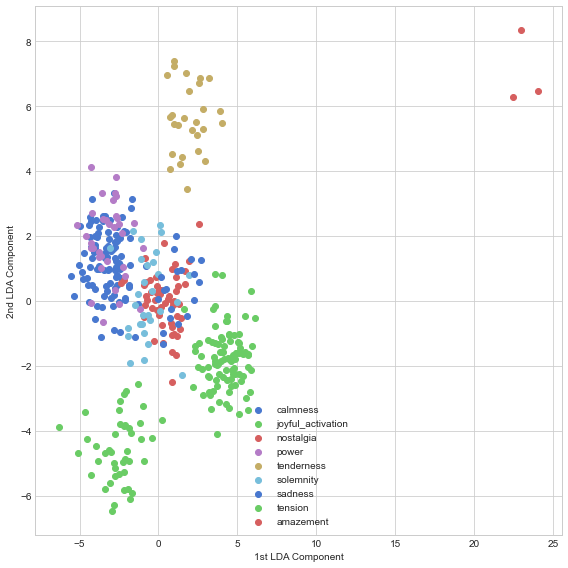

In [10]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda.fit(features, labels)

projected_features = lda.transform(features)

# Saving the LDA to a joblib file
joblib_file = "projected.features"
joblib.dump(lda, joblib_file)

print(projected_features.shape)

#Plotting to show how the tracks were classified
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 1],
                    projected_features[labels==lab_val, 4],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

# The Machine Learning

The following code bracket is splitting the features and labels into testing and training groups (30/70), followed by the actual machine learning algorithm (a support vector machine).

0 of 120 music files were wrongly classified, and the model succeeds with 100 % accuracy.

The machine learning model is exported as a file that can be used to label new music tracks.

In [11]:
#Splitting the set of features into testing and testing set
from sklearn.model_selection import train_test_split

feat_train, feat_test, lab_train, lab_test = train_test_split(projected_features, labels, test_size=0.3, random_state=776)


#Creating an instance of a SVM classifier
#and setting it to use a linear kernel
model_SVM = sklearn.svm.SVC(kernel='linear', C=1.0)

#training the model
model_SVM.fit(feat_train, lab_train)

joblib_file3 = "magic.SVM"
joblib.dump(model_SVM, joblib_file3)

#applying the the model on the test data (features)
lab_predict =  model_SVM.predict(feat_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 0 out of 120
Accuracy: 1.0


In [7]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        23
         2.0       1.00      1.00      1.00        20
         3.0       1.00      1.00      1.00         9
         4.0       1.00      1.00      1.00        13
         5.0       1.00      1.00      1.00         6
         6.0       1.00      1.00      1.00         4
         7.0       1.00      1.00      1.00        13
         8.0       1.00      1.00      1.00         2

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

[[30  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0  0  2]]
